In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Define constants
mass = 39.95*1.68*10**(-27)
epsilon = 119.8/1.381*10**(-23)
sigma = 3.405 #angstrom
Electric_Charge = 1
Epsilon_0 = 8.85*10**(-12)*sigma*epsilon*Electric_Charge**2
N_Particles = 32

#User input
rho = 0.3 #units of sigma**-3, N*m/L^3
Temperature = 3.0
Box_Size = (N_Particles/rho)**(1/3)
Lattice_Size = Box_Size/3
#Box_Size = 100
#Lattice_Size = 3.12354
Particle_Charge = -1*Electric_Charge
E_Field = 0.2

In [3]:
#Functions

def Force(A_Position,B_Position):
    Sequence_Polarity = np.array(A_Position>B_Position)*2 -1
    Image_Polarity = np.array(np.power((A_Position-B_Position),2)>(Box_Size/2)**(2))
    Distances = (Image_Polarity*Box_Size-np.abs(A_Position-B_Position))
    Distance = np.sum(np.power(Distances,2))**(0.5)
    Lennard_Jones_pot = 4*(Distance**(-6) - Distance**(-12))
    Total_Force = 4*(6/(Distance)**(7) - 12/(Distance)**(13))
    Directions = Distances*Sequence_Polarity
    Forces = (Directions/Distance)*Total_Force
    Forces[2] += Particle_Charge*E_Field
    return Forces, Lennard_Jones_pot, Distance, Total_Force

#Maybe write to file multiple times and get values from this file to get <n(r)>
#Or run code again and use Distance_List1, Distance_List2 etc
Distance_List = []
def Dist_Pair_Corr(Distance):
    Distance_List.append(Distance)

Delta_r = Lattice_Size/20
Pair_Corr_Bins = np.arange(0, 3*Lattice_Size/2, Delta_r)
Pair_Corr_r_List = []
#Calculated for each [r, r+delta_r]
#Distance here is every value of Pair_Corr_Bins
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Bin_Size)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

Pressure_LJ_Pot_list = []
def Average_LJ_Pot(Distance, Total_Force):
    Pressure_LJ_Pot = Distance*Total_Force
    Pressure_LJ_Pot_list.append(Pressure_LJ_Pot)
    return Pressure_LJ_Pot_list

In [4]:
E_kin_initial = np.array([0.0])
E_pot_initial = np.array([0.0])

T = 0.5 #units epsilon/k_B = 119.8 K, is input of user


rho = 1.2 #input of user, units of sigma**-3, N*m/L^3

n_particles = 32

#Positions of atoms
pos = np.zeros((n_particles,6))





# unit_cell = np.array([[Lattice_Size/2,Lattice_Size/2,Lattice_Size/2],
#                       [Lattice_Size,Lattice_Size,Lattice_Size/2],
#                       [Lattice_Size,Lattice_Size/2,Lattice_Size],
#                       [Lattice_Size/2,Lattice_Size,Lattice_Size]])

unit_cell = np.array([[0,0,0],
                       [0,Lattice_Size,Lattice_Size],
                       [Lattice_Size,0,Lattice_Size],
                       [Lattice_Size,Lattice_Size,0]])




                      

print(type(unit_cell))
print(np.shape((np.tile([1,2,3],4).reshape(4,3))))

#Number of cells
Nx = 2
Ny = 2
Nz = 2
Step = 0
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            pos[Step:Step+4,:3] = (unit_cell + np.tile([i,j,k],4).reshape(4,3))
            Velocities = np.zeros((4,3))
            for l in range(int(np.size(unit_cell)/3)):
                vx = np.random.normal(0, np.sqrt(T))
                vy = np.random.normal(0, np.sqrt(T))
                vz = np.random.normal(0, np.sqrt(T))
                Velocities[l,:] = np.array([vx,vy,vz])
                
            
            pos[Step:Step+4,3:] = Velocities
            Step += int(np.size(unit_cell)/3)


<class 'numpy.ndarray'>
(4, 3)


In [5]:
#Check if any particle is initialised outside the periodic box

for n in range(n_particles):
    for p in range(Nx):
        if pos[n, p] >= Box_Size or pos[n,p] < 0:
            print('particle_' , n, '  axis_' , p)
for n in range(n_particles):
    for m in range(n_particles):
        if m != n:
            if pos[n,0] == pos[m,0] and pos[n,1] == pos[m,1] and pos[n,2] == pos[m,2]:
                print(n , m)

In [6]:
#L=10
Iterations = 12000

#Fiducial extreme values of lambda. Inside these we assume the system is in thermal equilibrium
lambda_min = 0.9
lambda_max = 1.1


Dimensions = 3

Historic_Positions = np.zeros((N_Particles,Dimensions,Iterations))
Historic_Velocities = np.zeros((N_Particles,Dimensions,Iterations))

Positions = pos[:,:3]
Velocities = pos[:,3:]
Historic_Positions[:,:,0] = Positions
Historic_Velocities[:,:,0] = Velocities

Energy = np.zeros((Iterations,3))

Timestep = 0.0001


for t in range(Iterations-1):
#     if t <= 2000:
#         Timestep = 0.0001
#     if t > 2000:
#         Timestep = 0.001

    Energy[t,0] = np.sum(0.5*Velocities[:,:]**2)
    if t == 0:
        Energy[t,1] = 0
    else:
        Energy[t,1] = -np.sum(Pot_En)
    Energy[t,2] = Energy[t,0] + Energy[t,1]
    #print("v",Velocities)
    Forces = np.zeros((N_Particles,Dimensions))
    Pot_En = np.zeros((N_Particles,Dimensions))
    for i in range(N_Particles):
        for j in range(N_Particles):
            if (i != j):
                Added_Forces, LJ_En, Distance, Total_Force = Force(Positions[i,:],Positions[j,:])
                Forces[i] += Added_Forces
                Pot_En[i] += LJ_En
                if i < j and t in range(Iterations-10, Iterations-5):
                    Dist_Pair_Corr(Distance)
                    Pressure_Value = Average_LJ_Pot(Distance, Total_Force)
                
    Positions = (Historic_Positions[:,:,t] + Velocities*Timestep + Forces*(Timestep**2)/2)%Box_Size
    Historic_Positions[:,:,t+1] = Positions
    if (t>0):
        Velocities = Historic_Velocities[:,:,t-1] + (Historic_Forces+Forces)*(Timestep/2)
        Historic_Velocities[:,:,t] = Velocities
    Historic_Forces = Forces
#     if (t%10) == 0 and t <= 20:
#         print(t)
#     if t%2 == 0:
    lmbd = np.sqrt((n_particles -1)*3*T/Energy[t,0])
    if t <= 2000:    
        if lmbd < lambda_min or lmbd > lambda_max:
            Historic_Velocities[:,:,t] = Velocities * lmbd
    
    if (t%100) == 0 and t>0:
        print(t)
        print('lambda = ', lmbd)


100
lambda =  0.7885802593421875
200
lambda =  0.9876123214092396
300
lambda =  1.142489624999241
400
lambda =  0.8767261287882663
500
lambda =  0.99663845045076
600
lambda =  1.1216148601001033
700
lambda =  0.8932162485052596
800
lambda =  1.1065780908141736
900
lambda =  1.1079381097144392
1000
lambda =  1.1089972483380794
1100
lambda =  1.1097242073798124
1200
lambda =  1.1101800626837537
1300
lambda =  1.1104304594450318
1400
lambda =  1.1105749404082164
1500
lambda =  0.9996182463733427
1600
lambda =  0.9996555349825894
1700
lambda =  0.9996912835277079
1800
lambda =  0.9997244857793458
1900
lambda =  0.9997514688205084
2000
lambda =  0.9000077222490463
2100
lambda =  0.8915790663104971
2200
lambda =  0.8836459796195758
2300
lambda =  0.875702603810981
2400
lambda =  0.8673535051542272
2500
lambda =  0.8583203225758419
2600
lambda =  0.8484340315600176
2700
lambda =  0.8376196390193061
2800
lambda =  0.8258779558344701
2900
lambda =  0.8132673609747663
3000
lambda =  0.7998872301

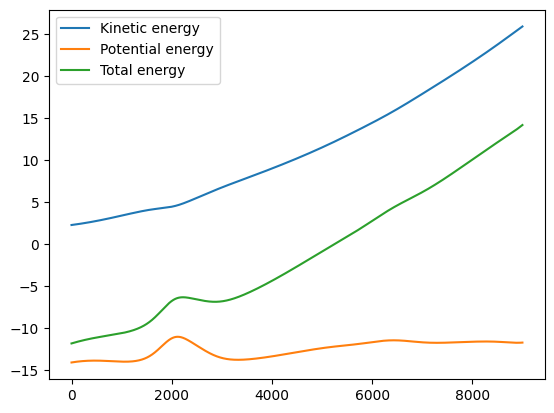

In [10]:
start_plot = 3000

plt.plot(Energy[start_plot:-1,0]/n_particles, label = 'Kinetic energy')
plt.plot(Energy[start_plot:-1,1]/n_particles, label = 'Potential energy')
plt.plot(Energy[start_plot:-1,2]/n_particles, label = 'Total energy')
# plt.yscale('log')
plt.legend()


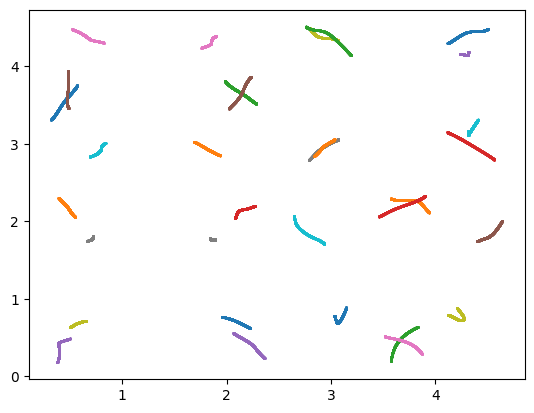

In [8]:
for m in range(n_particles):
    plt.scatter(Historic_Positions[m,0,8000:], Historic_Positions[m,1,8000:], s = 0.1)


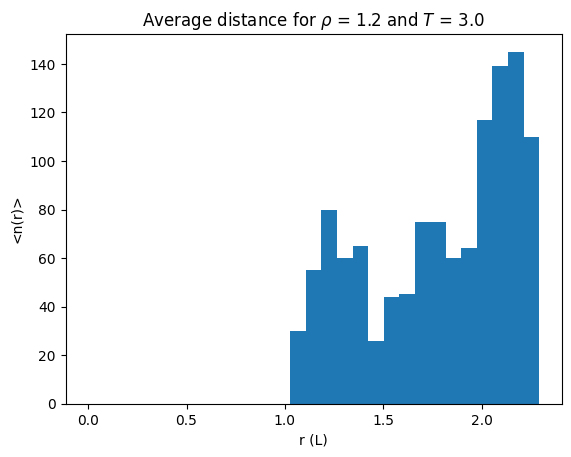

In [11]:
Avg_n = plt.hist(Distance_List, bins = Pair_Corr_Bins)
plt.xlabel('r (L)')
plt.ylabel('<n(r)>')
plt.title(r'Average distance for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()


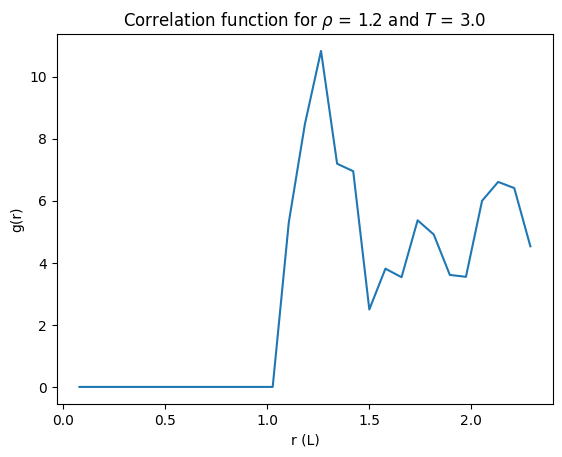

In [12]:
Pair_Corr_r_List = []
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Delta_r)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

for Average_n, Distance_r in zip(Avg_n[0], Pair_Corr_Bins[1:]):
    Pair_Corr_function(Average_n, Distance_r)


plt.plot(Pair_Corr_Bins[1:], Pair_Corr_r_List)
plt.xlabel('r (L)')
plt.ylabel('g(r)')
plt.title(r'Correlation function for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()


In [13]:
#Pressure
#To get average over multiple initial conditions, save the Pressure_Value_Total ssomewhere
# and run the simulation multiple times
Pressure_Value_Total = np.sum(Pressure_Value)/len(Pressure_Value)
print(Pressure_Value_Total)
Pressure = 1 - (3*N_Particles)*0.5*Pressure_Value_Total
print(Pressure)

0.4061395366152767
-18.49469775753328


In [ ]:
# %matplotlib notebook

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for l in range(n_particles):
#     ax.scatter(Historic_Positions[l,0,2000:],Historic_Positions[l,1,2000:], Historic_Positions[l,2,2000:])

# ax.view_init(elev=8., azim=60.)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# plt.show()